<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [2]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import cv2
import hashlib

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [4]:
def show_image(image, title=None):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  if title is not None:
    plt.title(title)
  plt.show()

In [5]:
def show_prediction(image, label, prediction):
  title = "Prediction: %s / Truth: %s" % (np.argmax(prediction), label)
  show_image(image, title)

In [6]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    height_zoom = size[1] / cam.shape[0]
    width_zoom = size[0] / cam.shape[1]
    heatmap = sp.ndimage.zoom(cam, (height_zoom, width_zoom), order=2)
 
  return heatmap

In [7]:
def show_heatmap(img, cam, size, resize=True, title=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(img, alpha=0.5, cmap='Greys')
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  
  if title is not None:
    plt.title(title)
  
  plt.show()  

In [8]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [9]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [10]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [11]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [71]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [73]:
def get_prediction(model, test, idx=-1):
  if idx < 0:
    idx = random.randint(0, len(test[0]))

  image = test[0][idx]
  label = np.argmax(test[1][idx])
  prediction = predict(model, image)

  return image, label, prediction, idx

In [13]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

#MNIST

In [14]:
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(10, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Epoch 1/15
422/422 [==============================] - 35s 6ms/step - loss: 0.9801 - accuracy: 0.6773 - val_loss: 0.1343 - val_accuracy: 0.9598
Epoch 2/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1919 - accuracy: 0.9406 - val_loss: 0.0851 - val_accuracy: 0.9740
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1263 - accuracy: 0.9611 - val_loss: 0.0648 - val_accuracy: 0.9808
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0934 - accuracy: 0.9708 - val_loss: 0.0503 - val_accuracy: 0.9853
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.0423 - val_accuracy: 0.9868
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0721 - accuracy: 0.9772 - val_loss: 0.0530 - val_accuracy: 0.9832
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0603 - accuracy: 0.9810 - val_loss: 0.0334 - val_accuracy: 0.9905
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


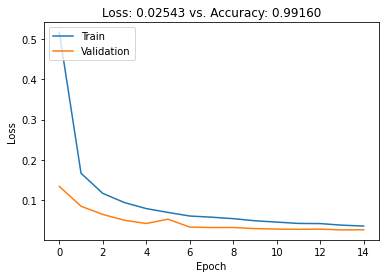

In [15]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), 10, mnist_train)

# model_mnist, history_mnist = load_model("gap_shallow")
start_time = time.clock()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

model_mnist.summary()
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)

plot_model_score(score_mnist, history_mnist.history)

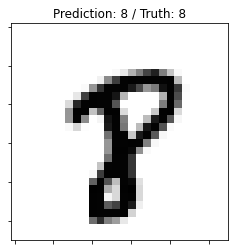

In [16]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [17]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [18]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
       
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.3),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

18841600/18841002 [==============================] - 2s 0us/step
(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


30/30 [==============================] - 2s 34ms/step - loss: 1.7654 - accuracy: 0.1684 - val_loss: 1.6812 - val_accuracy: 0.1452
Epoch 2/15
30/30 [==============================] - 1s 20ms/step - loss: 1.5696 - accuracy: 0.2888 - val_loss: 1.0535 - val_accuracy: 0.7095
Epoch 3/15
30/30 [==============================] - 1s 21ms/step - loss: 0.9412 - accuracy: 0.7093 - val_loss: 0.6430 - val_accuracy: 0.8500
Epoch 4/15
30/30 [==============================] - 1s 20ms/step - loss: 0.6476 - accuracy: 0.8132 - val_loss: 0.4999 - val_accuracy: 0.8500
Epoch 5/15
30/30 [==============================] - 1s 20ms/step - loss: 0.5049 - accuracy: 0.8436 - val_loss: 0.4086 - val_accuracy: 0.9143
Epoch 6/15
30/30 [==============================] - 1s 20ms/step - loss: 0.4313 - accuracy: 0.8570 - val_loss: 0.3573 - val_accuracy: 0.9024
Epoch 7/15
30/30 [==============================] - 1s 20ms/step - loss: 0.3758 - accuracy: 0.8884 - val_loss: 0.2808 - val_accuracy: 0.9333
Epoch 8/15
30/30 [======

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


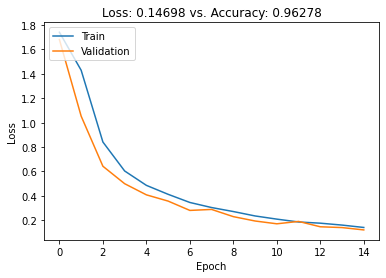

In [19]:
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(len(dataset[2]), geo_train, geo_test)
model_geo = create_geo_model("geocam", (28, 28, 1), len(dataset[2]))
# model_geo, history_geo = load_model("geo")

start_time = time.clock()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_geo, history_geo, "geo")

model_geo.summary()
score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)

plot_model_score(score_geo, history_geo.history)

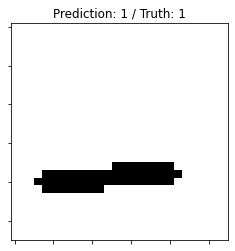

In [81]:
image, label, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, label, prediction)

# Transfer-learning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/20
422/422 [==============================] - 15s 33ms/step - loss: 1.8809 - accuracy: 0.3059 - val_loss: 2.1099 - val_accuracy: 0.2785
Epoch 2/20
422/422 [==============================] - 14s 33ms/step - loss: 0.9391 - accuracy: 0.7117 - val_loss: 1.0411 - val_accuracy: 0.5817
Epoch 3/20
422/422 [==============================] - 14s 33ms/step - loss: 0.6061 - accuracy: 0.8158 - val_loss: 0.8194 - val_accuracy: 0.6902
Epoch 4/20
422/422 [==============================] - 14s 33ms/step - loss: 0.4886 - accuracy: 0.8487 - val_loss: 0.6391 - val_accuracy: 0.7588
Epoch 5/20
422/422 [==============================] - 14s 33ms/step - loss: 0.4287 - accuracy: 0.8697 - val_loss: 0.6424 - val_accuracy: 0.7577
Epoch 6/20
422/422 [==============================] - 14s 33ms/step - loss: 0.3782 - accuracy: 0.8832 - val_loss: 0.7590 - val_accuracy: 0.7085
Epoch 7/20
422/422 [==============================] - 14s 33ms/step - loss: 0.3498 - accuracy: 0.8941 - val_loss: 0.4861 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 128)     

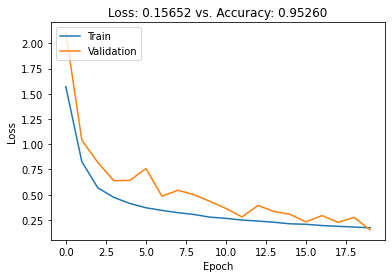

In [46]:
geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
mnist_layers = get_cam_layers(keras.models.clone_model(model_mnist))

model_gcm = keras.Sequential()

for layer in geo_layers[0]:
  layer.trainable = False
  model_gcm.add(layer)

model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.Dropout(0.4))
# model_gcm.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.GlobalAveragePooling2D())
model_gcm.add(layers.Dense(10, activation="softmax"))

# for layer in mnist_layers[1]:
  # model_gcm.add(layer)

opt = keras.optimizers.Adam(learning_rate=0.002)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start_time = time.clock()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=20, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))

score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
model_gcm.summary()
plot_model_score(score_gcm, history_geocam.history)

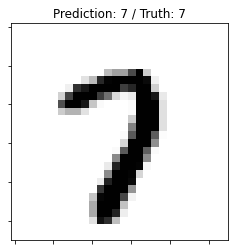

In [44]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# CAMs

In [23]:
def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  heatmap_model = Model([model.inputs], [cam_layers[0][con_layer_idx].get_output_at(0), model.output])

  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = heatmap_model(np.expand_dims(image, 0))
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, prediction_idx, (conv_first_grad, conv_second_grad, conv_third_grad)

In [24]:
def cam_1(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[1][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

conv output hash: BD57E0213BD3C63D07C19181FA78DFF2A6475FCFF57C2DE3C52EC0363B9A26A0


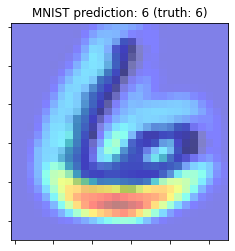

In [169]:
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
conv_output_hash = hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()

print(f"conv output hash: {conv_output_hash}")
title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, (28, 28, 1), True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

[0.50323564 0.9870464  1.         0.9128068  0.6101653  0.52237815]
[2 1 3 4 5 0]
1st : diagonal (100.00%)
2nd : horizontal (98.70%)
3rd : ellipse (91.28%)


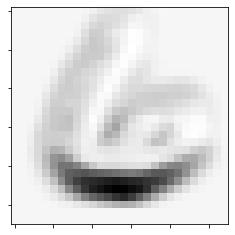

In [170]:
image = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
prediction = predict(model_geo, image)

labels = dataset[2]
sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(percentages)
print(sorted_indexes)

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

show_image(image)

GEO prediction: lower_than (idx: 5)


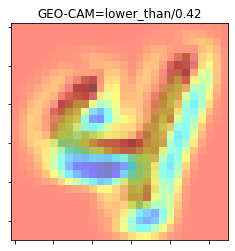

In [64]:
# CAM for GEO NN (Knowledge Domain Network)
geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
model_gcg = keras.Sequential()
for layer in geo_layers[1]:
  model_gcg.add(layer)

# Prediction
gcg_predictions = model_gcg(gcm_conv_output)
gcg_prediction_idx = np.argmax(gcg_predictions)
geo_prediction_label = dataset[2][gcg_prediction_idx]
print(f"GEO prediction: {geo_prediction_label} (idx: {gcg_prediction_idx})")

# CAM projection
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, gcg_prediction_idx)
gcg_mnist_cam_max = np.max(gcg_mnist_cam)

# Debug
title = "GEO-CAM=%s/%.2f" % (geo_prediction_label, gcg_mnist_cam_max)
show_heatmap(test_mnist_image, gcg_mnist_cam, (28, 28, 1), True, title)